In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install eli5

     |████████████████████████████████| 112kB 3.5MB/s 


In [0]:
import os, time, json, re, copy, gc
import itertools, argparse, pickle, random
import os.path as osp

from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import nltk
from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score

import matplotlib
import matplotlib.pyplot as plt

# import eli5
# from eli5.lime import TextExplainer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR, StepLR, MultiStepLR, ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, Sampler

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [0]:
USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [0]:
SEED = 2019
path = '/content/'

# Seed pytorch
def seed_torch(seed=SEED):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Convert target and identity columns to booleans    
def convert_dataframe_to_bool(df):
    def convert_to_bool(df, col_name):
        df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
    bool_df = df.copy()
    for col in [label_column] + identity_columns + aux_columns:
        convert_to_bool(bool_df, col)
    return bool_df

## Loading data, preprocessing and batchifying

### Download data

In [0]:
!mkdir /root/.kaggle
!cp /content/drive/My\ Drive/DL_projects/Data/kaggle.json /root/.kaggle/

In [6]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f train.csv

 94% 257M/273M [00:05<00:00, 41.1MB/s]
100% 273M/273M [00:05<00:00, 55.3MB/s]


In [7]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification -f test.csv

 42% 5.00M/12.0M [00:00<00:00, 22.7MB/s]
100% 12.0M/12.0M [00:00<00:00, 34.5MB/s]


In [8]:
!unzip train.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               


In [9]:
!unzip test.csv.zip

Archive:  test.csv.zip
  inflating: test.csv                


In [0]:
!rm train.csv.zip test.csv.zip

### Loading and preprocessing

In [0]:
vocab_size = 100000
max_len = 220

In [0]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

aux_columns = ['target', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack']

label_column = 'target'
pred_column = 'prediction'
text_column = 'comment_text'

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
symbols_to_isolate = ''.join(puncts)
isolate_dict = {ord(c):f' {c} ' for c in symbols_to_isolate}

def clean_punc(x):
    x = str(x)
    x = x.translate(isolate_dict)
    return x

def clean_text(raw):
    return clean_punc(raw.lower()).strip()

In [0]:
def word_idx_map(raw_comments, vocab_size):
    """
    :return: word, index mapping
    """
    def build_vocab(sentences):
        """
        :param sentences: list of list of words
        :return: dictionary of words and their count
        """
        vocab = {}
        for sentence in sentences:
            for word in sentence:
                try:
                    vocab[word] += 1
                except KeyError:
                    vocab[word] = 1
        return vocab

    def most_common_vocab(vocab, k):
        """
        :param vocab: dictionary of words and their count
        :k: former k words to return
        :return: list of k most common words
        """
        sorted_vocab = sorted([(cnt,w) for w,cnt in vocab.items()])[::-1]
        return [(w,cnt) for cnt,w in sorted_vocab][:k]

    texts = [c.split() for c in raw_comments]
    word_freq = build_vocab(texts)
    vocab_freq = most_common_vocab(word_freq, vocab_size)
    idx_to_word = ['<pad>'] + [word for word, cnt in vocab_freq] + ['<unk>']
    word_to_idx = {word:idx for idx, word in enumerate(idx_to_word)}

    return word_to_idx, idx_to_word

def tokenize(comments, word_to_idx, maxlen):
    '''
    Tokenize and numerize the comment sequences
    Inputs:
    - comments: pandas series of comments
    - word_to_idx: word to index mapping
    - maxlen: max length of each sequence of tokens

    Returns:
    - tokens: list of sequences (also list of tokens with length maxlen)
              with length data_size
    '''

    def text_to_id(c, word_to_idx, maxlen):
        return [(lambda x: word_to_idx[x] if x in word_to_idx else word_to_idx['<unk>'])(w) \
                 for w in c.split()[-maxlen:]]

    return np.array([text_to_id(c, word_to_idx, maxlen) for c in comments])

In [0]:
def load_and_preproc():
    train_df = pd.read_csv(path+'train.csv')
    test_df = pd.read_csv(path+'test.csv')
    train_df[identity_columns] = train_df[identity_columns].copy().fillna(0)

    print('cleaning text...')
    t0 = time.time()
    train_df[text_column] = train_df[text_column].apply(clean_text)
    test_df[text_column] = test_df[text_column].apply(clean_text)
    print('cleaning complete in {:.0f} seconds.'.format(time.time()-t0))

    sample_weights = np.ones(len(train_df))
    sample_weights += train_df[identity_columns].values.sum(1) * 3
    sample_weights += train_df[label_column].values * 8
    sample_weights /= sample_weights.max()
    train_tars = train_df[[label_column]+aux_columns+identity_columns].values
    train_tars = np.hstack([train_tars, sample_weights[:,None]]).astype('float32')

    train_df = convert_dataframe_to_bool(train_df)
    df = train_df[[label_column]+identity_columns].copy()
    df[label_column] = df[label_column].astype('uint8')

    return train_df[text_column], train_tars, test_df[text_column], df

In [15]:
%%time
np.random.seed(SEED)
train_seq, train_tars, x_test, trn_df = load_and_preproc()

cleaning text...
cleaning complete in 42 seconds.
CPU times: user 56 s, sys: 1.7 s, total: 57.7 s
Wall time: 57.7 s


In [16]:
%%time
word_to_idx, idx_to_word = word_idx_map(train_seq.tolist()+x_test.tolist(), vocab_size)
del x_test

CPU times: user 52.9 s, sys: 2.9 s, total: 55.8 s
Wall time: 55.8 s


### train/val split

In [0]:
trn_df.shape

(1804874, 10)

In [0]:
def train_val_split(train_x, train_y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_indices = [(tr_idx, val_idx) for tr_idx, val_idx in kf.split(train_x, train_y)]
    return cv_indices

cv_indices = train_val_split(train_seq, (train_tars[:,0]>=0.5).astype(int))

In [0]:
trn_idx, val_idx = cv_indices[0]

x_train, x_val = train_seq[trn_idx], train_seq[val_idx]
y_train, y_val = train_tars[trn_idx], train_tars[val_idx]

In [0]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1443899,), (360975,), (1443899, 17), (360975, 17))

In [0]:
trn_df[trn_df['target']==1][:10]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
4,1,False,False,False,False,False,False,False,False,False
5,1,False,False,False,False,False,False,False,False,False
13,1,False,False,False,False,False,False,False,False,False
14,1,False,False,False,False,False,False,False,False,False
19,1,False,False,False,False,False,False,False,False,False
31,1,False,False,False,True,False,True,False,False,False
34,1,False,True,False,False,False,False,False,False,False
84,1,False,False,False,False,False,False,False,False,False
105,1,False,False,False,False,False,False,False,False,False
123,1,False,False,False,False,False,False,False,False,False


In [19]:
val_df = trn_df.iloc[val_idx]
val_df[val_df['target']==1][:10]

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness
5,1,False,False,False,False,False,False,False,False,False
31,1,False,False,False,True,False,True,False,False,False
105,1,False,False,False,False,False,False,False,False,False
189,1,False,False,False,False,False,False,False,True,False
289,1,False,False,False,False,False,False,False,False,False
379,1,False,False,False,False,False,False,False,False,False
523,1,False,False,False,False,False,False,False,False,False
534,1,False,False,False,False,False,False,False,False,False
561,1,False,False,False,False,False,False,False,False,False
649,1,False,False,False,False,False,False,False,False,False


In [0]:
del train_seq, train_tars, trn_df

In [21]:
print('tokenizing...')
t0 = time.time()
x_val = tokenize(x_val, word_to_idx, max_len)
print('tokenizing complete in {:.0f} seconds.'.format(time.time()-t0))

tokenizing...
tokenizing complete in 11 seconds.


### data loader

In [0]:
# Prepare dataset and dataloader
class Toxic_comments(Dataset):

    def __init__(self, tokenized_comments, targets=None, split=None, maxlen=256):
        self.comments = tokenized_comments
        self.targets = targets
        self.split = split
        assert self.split in {'train', 'valid', 'test'}
        self.maxlen = maxlen

    def __getitem__(self, index):
        comment = self.comments[index]
        if self.targets is not None:
            target = self.targets[index]
            return comment, torch.FloatTensor(target)
        else:
            return comment

    def __len__(self):
        return len(self.comments)

    def get_lens(self):
        lengths = np.fromiter(
            ((min(self.maxlen, len(seq))) for seq in self.comments),
            dtype=np.int32)
        return lengths

    def collate_fn(self, batch):
        """
        Collate function for sequence bucketing
        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of comments, and targets
        """

        if self.split in ('train', 'valid'):
            comments, targets = zip(*batch)
        else:
            comments = batch

        lengths = [len(c) for c in comments]
        maxlen = max(lengths)
        padded_comments = []
        for i, c in enumerate(comments):
            padded_comments.append([0]*(maxlen - lengths[i])+c)

        if self.split in ('train', 'valid'):
            return torch.LongTensor(padded_comments), torch.stack(targets)
        else:
            return torch.LongTensor(padded_comments)


class BucketSampler(Sampler):

    def __init__(self, data_source, sort_lens, bucket_size=None, batch_size=1024, shuffle_data=True):
        super().__init__(data_source)
        self.shuffle = shuffle_data
        self.batch_size = batch_size
        self.sort_lens = sort_lens
        self.bucket_size = bucket_size if bucket_size is not None else len(sort_lens)
        self.weights = None

        if not shuffle_data:
            self.index = self.prepare_buckets()
        else:
            self.index = None

    def set_weights(self, weights):
        assert weights >= 0
        total = np.sum(weights)
        if total != 1:
            weights = weights / total
        self.weights = weights

    def __iter__(self):
        indices = None
        if self.weights is not None:
            total = len(self.sort_lens)
            indices = np.random.choice(total, (total,), p=self.weights)
        if self.shuffle:
            self.index = self.prepare_buckets(indices)
        return iter(self.index)

    def get_reverse_indexes(self):
        indexes = np.zeros((len(self.index),), dtype=np.int32)
        for i, j in enumerate(self.index):
            indexes[j] = i
        return indexes

    def __len__(self):
        return len(self.sort_lens)

    def prepare_buckets(self, indices=None):
        lengths = - self.sort_lens
        assert self.bucket_size % self.batch_size == 0 or self.bucket_size == len(lengths)

        if indices is None:
            if self.shuffle:
                indices = shuffle(np.arange(len(lengths), dtype=np.int32))
                lengths = lengths[indices]
            else:
                indices = np.arange(len(lengths), dtype=np.int32)

        #  bucket iterator
        def divide_chunks(l, n):
            if n == len(l):
                yield np.arange(len(l), dtype=np.int32), l
            else:
                # looping till length l
                for i in range(0, len(l), n):
                    data = l[i:i + n]
                    yield np.arange(i, i + len(data), dtype=np.int32), data

        new_indices = []
        extra_batch_idx = None
        for chunk_index, chunk in divide_chunks(lengths, self.bucket_size):
            # sort indices in bucket by descending order of length
            indices_sorted = chunk_index[np.argsort(chunk)]

            batch_idxes = []
            for _, batch_idx in divide_chunks(indices_sorted, self.batch_size):
                if len(batch_idx) == self.batch_size:
                    batch_idxes.append(batch_idx.tolist())
                else:
                    assert extra_batch_idx is None
                    assert batch_idx is not None
                    extra_batch_idx = batch_idx.tolist()

            # shuffling batches within buckets
            if self.shuffle:
                batch_idxes = shuffle(batch_idxes)
            for batch_idx in batch_idxes:
                new_indices.extend(batch_idx)

        if extra_batch_idx is not None:
            new_indices.extend(extra_batch_idx)

        if not self.shuffle:
            self.original_indices = np.argsort(indices_sorted).tolist()
        return indices[new_indices]


def prepare_loader(x, y=None, batch_size=1024, split=None):
    assert split in {'train', 'valid', 'test'}
    dataset = Toxic_comments(x, y, split, max_len)
    if split == 'train':
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                bucket_size=batch_size*30, batch_size=batch_size)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn)
    else:
        sampler = BucketSampler(dataset, dataset.get_lens(),
                                batch_size=batch_size, shuffle_data=False)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler,
                          collate_fn=dataset.collate_fn), sampler.original_indices

In [0]:
val_loader, val_original_indices = prepare_loader(x_val, y_val, split='valid')

## Load embeddings

In [0]:
def load_embeddings(path):
    with open(path,'rb') as f:
        emb_index = pickle.load(f)
    return emb_index

def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')

def get_embedding(embedding_file, word_to_idx, embedding_dim=300):
    # with open(embedding_file, encoding="utf8", errors='ignore') as f:
    #     embeddings_index = dict(get_coefs(*o.split(' ')) for o in f if len(o)>100)
    print(f'loading {embedding_file}')
    embeddings_index = load_embeddings(embedding_file)

    all_embs = np.stack([emb for emb in embeddings_index.values() if len(emb)==embedding_dim])
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    nb_words = len(word_to_idx)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_dim))
    for word, i in word_to_idx.items():
        if i > nb_words: break
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.upper())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
        embedding_vector = embeddings_index.get(word.title())
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            continue
    return embedding_matrix

In [25]:
os.chdir('/content/drive/My Drive/DL_projects/nlp_jigsaw_bias')
os.listdir('../Data/wordvecs')

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'GoogleNews-vectors-negative300',
 'glove.840B.300d',
 'paragram_300_sl999',
 'wiki-news-300d-1M',
 'crawl-300d-2M.pkl',
 'paragram_300_sl999.pkl',
 'glove.840B.300d.pkl',
 'wiki-news-300d-1M.pkl']

In [26]:
%%time
EMBEDDING_FILE = '../Data/wordvecs/crawl-300d-2M.pkl'
embed_mat = get_embedding(EMBEDDING_FILE, word_to_idx)

loading ../Data/wordvecs/crawl-300d-2M.pkl
CPU times: user 14.7 s, sys: 7.75 s, total: 22.5 s
Wall time: 51.1 s


In [0]:
embed_mat.shape

(100002, 300)

## Load model

In [0]:
class SpatialDropout(nn.Dropout2d):
    def forward(self, x):
        x = x.unsqueeze(-1)    # (N, T, M, 1)
        x = x.transpose(1,2)   # (N, M, T, 1)
        x = super(SpatialDropout, self).forward(x)  # (N, M, T, 1), some features are masked
        x = x.squeeze(-1)     # (N, M, T)
        x = x.transpose(1,2)   # (N, T, M)
        return x

class EmbeddingLayer(nn.Module):

    def __init__(self, vocab_size, embed_dim, embed_matrix):
        super(EmbeddingLayer, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.emb.weight = nn.Parameter(torch.tensor(embed_matrix, dtype=torch.float32))
        self.emb_dropout = SpatialDropout(0.35)

    def forward(self, seq):
        emb = self.emb(seq)
        emb = self.emb_dropout(emb)
        return emb

class RecurrentNet(nn.Module):

    def __init__(self, embed_dim, hidden_dim):
        super(RecurrentNet, self).__init__()
        # Init layers
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_dim*2, hidden_dim, bidirectional=True, batch_first=True)

        for mod in (self.lstm, self.gru):
            for name, param in mod.named_parameters():
                if 'weight_ih' in name:
                    nn.init.xavier_uniform_(param)
                if 'weight_hh' in name:
                    nn.init.orthogonal_(param)

    def forward(self, seq):
        o_lstm, _ = self.lstm(seq)
        o_gru, _ = self.gru(o_lstm)
        return o_gru

class CommentClassifier(nn.Module):

    def __init__(self, hidden_dim, output_dim):
        super(CommentClassifier, self).__init__()
        self.dropout = nn.Dropout(0.1)
        self.fc_out = nn.Linear(hidden_dim*4, output_dim)

    def forward(self, seq):
        avg_pool = torch.mean(seq, 1)
        max_pool, _ = torch.max(seq, 1)
        h_concat = torch.cat((avg_pool, max_pool), 1)
        out = self.fc_out(self.dropout(h_concat))
        return out

class JigsawNet(nn.Module):

    def __init__(self, vocab_size, embed_dim, hidden_dim, embed_matrix):
        super(JigsawNet, self).__init__()
        # Init layers
        self.emb_layer = EmbeddingLayer(vocab_size, embed_dim, embed_matrix)
        self.rnns = RecurrentNet(embed_dim, hidden_dim)
        self.classifier = CommentClassifier(hidden_dim, 16)

    def forward(self, seq):
        emb = self.emb_layer(seq)
        o_rnn = self.rnns(emb)
        out = self.classifier(o_rnn)

        return out

In [28]:
def model_test():
    x = torch.zeros((32, max_len), dtype=torch.long)
    x = x.to(device)
    
    model = JigsawNet(*embed_mat.shape, 128, embed_mat)
    model = model.to(device)
    scores = model(x)
    print(scores.size())

model_test()

torch.Size([32, 16])


In [29]:
models = torch.load('unbiased_models.pt')
model = JigsawNet(*embed_mat.shape, 128, embed_mat)
model.load_state_dict(models['fold_0'])

<All keys matched successfully>

## Evaluation

In [0]:
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, pred_column):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[pred_column])

def compute_bpsn_auc(df, subgroup, label, pred_column):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[pred_column])

def compute_bnsp_auc(df, subgroup, label, pred_column):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[pred_column])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

def calculate_overall_auc(df, pred_col, label_col):
    true_labels = df[label_col]
    predicted_labels = df[pred_col]
    return roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [0]:
def eval_model(model, data_loader, mode='test', target_only=True):
    assert mode in ('val', 'test')
    model.eval()
    test_scores = []
    with torch.no_grad():
        for x in data_loader:
            if mode=='val': x = x[0]
            x = x.to(device=device, dtype=torch.long)
            score = torch.sigmoid(model(x))[:,0] if target_only else torch.sigmoid(model(x))
            test_scores.append(score.cpu().numpy())
    return np.concatenate(test_scores)

In [0]:
model = model.to(device)
val_scores = eval_model(model, val_loader, mode='val')[val_original_indices]
val_df[pred_column] = val_scores
val_df.head()

,target,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,prediction
5,1,False,False,False,False,False,False,False,False,False,0.772251
8,0,False,False,False,False,False,False,False,False,False,0.162618
12,0,False,False,False,False,False,False,False,False,False,0.013891
16,0,False,False,False,False,False,False,False,False,False,0.323075
31,1,False,False,False,True,False,True,False,False,False,0.850130


In [0]:
bias_metrics_df = compute_bias_metrics_for_model(val_df, identity_columns, pred_column, label_column)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.964926,0.882786,homosexual_gay_or_lesbian,0.847989,2202
7,0.962868,0.895514,white,0.857556,5089
6,0.966300,0.883349,black,0.858693,3043
5,0.960737,0.913754,muslim,0.879690,4240
4,0.950789,0.942741,jewish,0.905326,1577
8,0.968467,0.937178,psychiatric_or_mental_illness,0.932990,1010
0,0.960824,0.951526,male,0.933938,8969
1,0.957207,0.956962,female,0.935398,10817
3,0.947613,0.967925,christian,0.941010,8015


In [0]:
get_final_metric(bias_metrics_df, calculate_overall_auc(val_df, pred_column, label_column))

0.9367367743841438

## Visualization

In [0]:
l_dtype = torch.cuda.LongTensor
f_dtype = torch.cuda.FloatTensor

def preprocessing(string):
    return tokenize([clean_text(string)], word_to_idx, max_len)

# compute gradients
def compute_backprop(X, y, net, class_label):
    net.eval()
    scores = net(X)
    correct_scores = scores[:,class_label].squeeze() if y==1 else 1-scores.squeeze()
    loss = correct_scores.sum()
    loss.backward()

# forward propagation for inference
def get_preds(x, net, class_label):
    net.eval()
    logit = net(x)
    prob = torch.sigmoid(logit[:,class_label]).detach().cpu().numpy()
    return prob

# feature extractor
def extract_features(x, net):
    net.eval()
    return net.rnns(net.emb_layer(x)).detach()   # (N, T, H)

class Net_classifier(nn.Module):
    def forward(self, x): return copy.deepcopy(model.classifier)(x)

class GradCAM(nn.Module):
    def __init__(self):
        super(GradCAM, self).__init__()
        self.ap = nn.AdaptiveAvgPool1d(1)
    
    def forward(self, feature_maps, feature_grads):
        # features size: (1, T, H) -> (1, H, T)
        map_weights = self.ap(feature_grads.transpose(1,2))   # (1, H, 1)
        maps = torch.sum(map_weights * feature_maps.transpose(1,2), 1)   # (1, T)
        grad_cam = F.relu(maps.squeeze(0))
        return grad_cam   # (T,)

def normalize_cam(cam):
    cam = cam - cam.min()
    return cam / cam.max() if cam.max()>0 else cam

def return_grad_cam(feature_maps, class_label):
    # generate the grad-CAM
    classifier = Net_classifier()
    
    feature_maps = f_dtype(feature_maps)
    feature_maps.requires_grad_()

    compute_backprop(feature_maps, 1, classifier, class_label)
    gradCAM = GradCAM()
    cam = gradCAM(feature_maps, feature_maps.grad).detach().cpu().numpy()  # (T,)
    return normalize_cam(cam)

def return_cam(features, weights):  # (T, 2*H), (4*H,)
    # generate the class activation maps (CAMs)
    D = len(weights)
    cam_avg = weights[:int(D/2)].dot(features.T)  # (T,)
    cam_avg = normalize_cam(cam_avg)
    cam_max = weights[int(D/2):].dot(features.T)  # (T,)
    cam_max = normalize_cam(cam_max)
    return cam_avg, cam_max

def plot_cam(x, y, figsize=(8,4), title=None):
    fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, figsize=figsize)
    
    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2., 0, 1]
    
    if title is not None:
        ax1.set_title(title, color='w')
    
    ax1.imshow(y[None,:], cmap="hot", aspect="auto", extent=extent)
    ax1.set_yticks([])
    ax1.set_xlim(extent[0], extent[1])

    ax2.plot(x,y)
    ax2.set_xlabel('Word position')
    ax2.set_ylabel('Attentive intensity')
    ax2.xaxis.label.set_color('w')
    ax2.yaxis.label.set_color('w')
    ax2.tick_params(axis='x', colors='w')
    ax2.tick_params(axis='y', colors='w')

    plt.tight_layout()
    plt.show()

def see_results(comment, targets):
    final_weights = list(model.parameters())[-2].cpu().detach().numpy()[0]   # (4*H)

    # non-padding length
    seq_len = len(comment[comment>0])
    print(' '.join([idx_to_word[idx] for idx in comment[comment>0]]))
    print()

    # get representations of comment
    features_rnn = extract_features(l_dtype(comment[-seq_len:]).unsqueeze(0), model)   # (1, T, 2*H)
    
    # get CAM of review
    cam_avg, cam_max = return_cam(features_rnn.squeeze(0).cpu().numpy(), final_weights)
    grad_cam = return_grad_cam(features_rnn, 0)
    attn_idxs = np.where(grad_cam > 0)[0]

    # print and plot
    print(f'with labels {targets[0].item()}')
    print(f'with prediction prob. {get_preds(l_dtype(comment).unsqueeze(0), model, 0)}')
    print()
    print('Words focused by grad-CAM:')
    print(' '.join([idx_to_word[idx] for idx in comment[-seq_len:][attn_idxs]]))
    print()
    plot_cam(list(range(seq_len)), (cam_avg+cam_max)/2, title=f"CAM of positive target")
    plot_cam(list(range(seq_len)), grad_cam, title=f"Grad_CAM of positive target")

In [0]:
model = model.cuda()
it = iter(val_loader)

In [0]:
# val samples
xs, ys = next(it)
xs, ys = xs.numpy(), ys.numpy()

In [51]:
np.where(ys[:,0]==1)[0]

array([306, 405, 555, 658])

actually , for some cultures the wait for the pfd pays off after a couple years . the cultures i ' m referring to tend to have very close family bonds that combine 3 to 4 generations in a single home . . i often agree with you on some subjects and find your input to be valuable . i was off - put to see you spouting the equivalent ignorant , racist , bigoted garbage that ' s been hurled at your religion . to me , it sounds ignorant when they do it and its sounds no different when you do . you speak of dog whistles , several of your posts above come off as anti - white racist rhetoric to me . do you really dislike white people ? or were you just trying to piss off their target ? . as far as the anti - samoan rhetoric ( not by you ) there are bad apples in every bunch . in my experience , nearly every samoan i ' ve met is good natured and very hard working . they are some of the most easy going people i ' ve ever met . " thug life " is affecting every race imo .

with labels 1.0
with pred

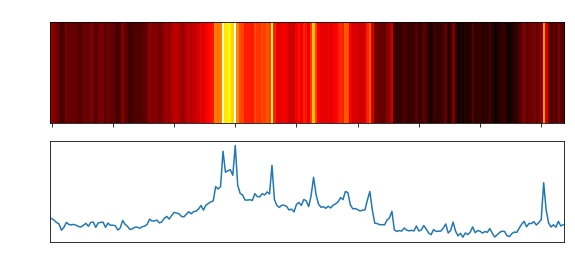

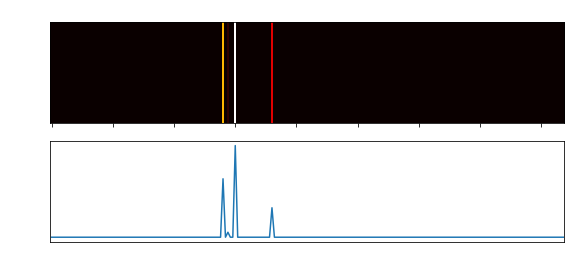

In [97]:
commt = xs[306]
tgs = ys[306]

see_results(commt, tgs)

yeah you ' d say so : as in your dumbass post : " white men are earth ' s alpha males . " dylann roof thinks so too . i ' d be too ashamed to even know you . here ' s some true facts for you and your ilk : from lisa bloom . lisa bloom is a legal analyst for nbc news and avvo , attorney and bestselling author . " in our nation ’ s history , so many of the sickest most appalling crimes have been committed by whites . yet no matter how sadistic the crime , no matter how young the victims , no matter how much fear is engendered in a community , no matter how much media attention and public discussion the crimes of whites engender , the race itself is never sullied . " lisa bloom also says white men are at the top of the list for gaining foreign visas to have sex with children . 85 - percent in latin america , she says . lisa bloom also adds the most prolific serial killers in this country ( america ) are white men . and last , white women are known for killing their children .

with labels

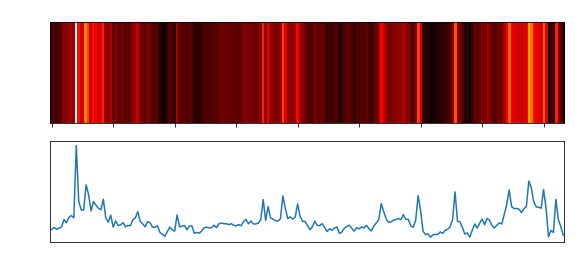

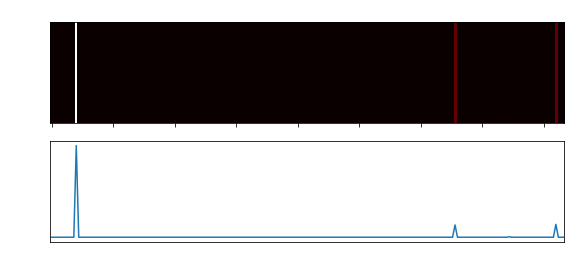

In [98]:
commt = xs[405]
tgs = ys[405]

see_results(commt, tgs)

In [0]:
# val samples
xs, ys = next(it)
xs, ys = xs.numpy(), ys.numpy()

In [0]:
np.where(ys[:,0]==1)[0]

array([ 341,  465,  828, 1009])

lol they all steal . we supported eu too . you think democrats don ' t enjoy it . now explain why both sides disliked trump ? probably because he heartened to bring down there game . thanks for pointing out that trump wasn ' t a thing during brexit . once again couldn ' t figure out the point . people dislike the guise of refugees / immigrants and the lovey dovey bs that goes along with it . i don ' t need a lesson on that and it was not even my point . once again trump and farage and the next eu leaders are very relative to the point of immigration . my second point was the fact that all countries steal from there citizens and launder . we citizens get screwed from every country . you can say the we launder to the usa but it ' s politicians , republican and democrat . the usa launders to me , canada etc and the liberals and conservatives here are happy . they all seem to dislike trump which should be a big clue to his relativity in not only immigration but all policies . once again i 

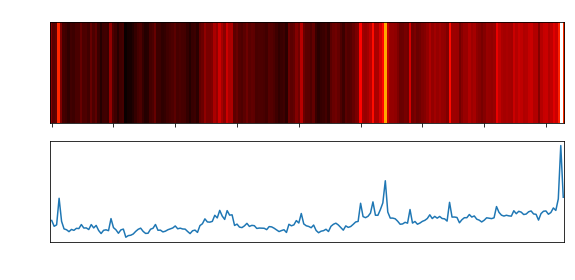

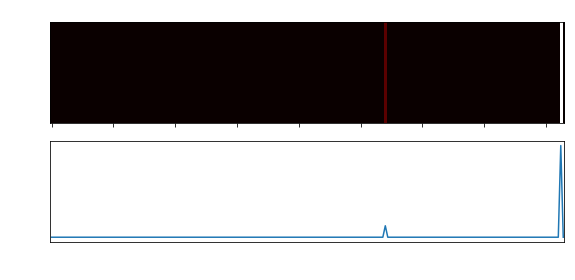

In [78]:
commt = xs[341]
tgs = ys[341]

see_results(commt, tgs)

no . you made it about race when you chose to act like some 0 . 3 % of murders are different from the other 99 . 6 % , more worthy of protest , and there was absolutely nothing else different about those 0 . 3 % . only seriously extreme racists ever use the term ' race card ' . complaining about the race card is proof of being a racist . non racists don ' t have any fear of discussing the influence of race on any topic . and only the really dumbest of the dumb use the word ' libtard ' . note how i discussed the issue in terms of numbers , facts , empirical reality untimely by emotion or group loyalty . i didn ' t ' bring race into it ' , i mathematically proved it could be about nothing else . and what could you offer in return ? any rational thoughts ? improved numbers ? a flaw in my calculation ? nope . all you have is a silly attempt at a personal insult . so i ' ve won this debate by all measures . just hush now . you ' re embarrassing yourself .

with labels 1.0
with prediction pr

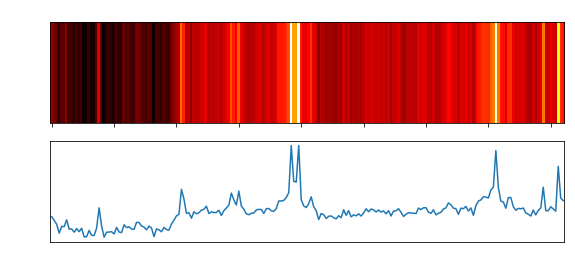

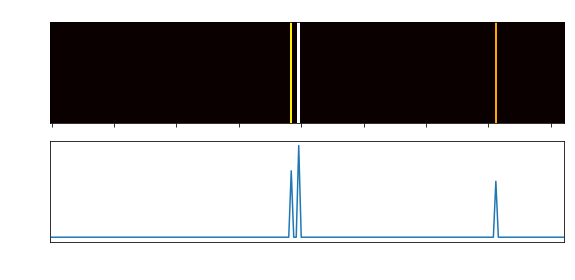

In [79]:
commt = xs[1009]
tgs = ys[1009]

see_results(commt, tgs)

In [73]:
np.where(ys[:,0]>=0.6)[0]

array([  26,   44,   59,   69,  118,  119,  188,  267,  328,  334,  341,
        389,  396,  403,  414,  452,  465,  476,  483,  504,  505,  552,
        591,  596,  642,  665,  753,  767,  828,  876,  899,  916,  961,
        964,  970,  986,  992, 1009])

something needs to be done about downtown . . . this is our city . the police have their hands tied so they end up having to expend all their energy chasing down drivers with a couple beers in their system instead of dealing with the bs from all the " travelers " downtown . i can ' t walk 5 ft without stepping on someone making a bed on the sidewalk or demanding my change or food from me . i get insulted and threatened constantly by smug , deranged addicts that seem more self - entitled than struggling . half of them are on heroin or meth and the others have serious mental health issues . one kid was threatening shop owners that if they didnt give him money store windows would be broken . these fools think these are their corners ? ? ? some need to be taught a lesson . we were kids on these corners years before these pan - handling scrubs were even out of diapers and we had respect and made our own way . we liked to gather because we loved music and community . . . now its being a thre

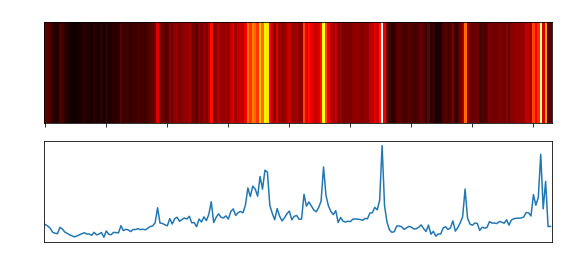

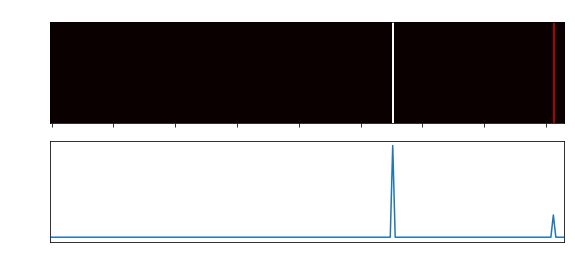

In [75]:
commt = xs[44]
tgs = ys[44]

see_results(commt, tgs)

right . perhaps texas a & m should have had better ' vetting ' . might have stopped charles j . whitman . maybe if milwaukee pd hadn ' t been so busy beating and executing folks for the crime of " driving while black " they would have caught jeffry dahmer with all those trash - bags full of " long - pig takeout " on the back seat of his car at 3 : 00 am . if the army more thoroughly " vetted " its recruits , maybe robert bales wouldn ' t have murdered 20 civilians in their beds . or if the chp had properly " vetted " patrolman craig <unk> he wouldn ' t have pulled over and groped kara knott , then bludgeoned and strangled her when she threatened to report him for it . what cracks me up is that all these " we don ' t need government to take care of us ! " - types seem to think that the way to stop crime ( at least when committed by muslims ) is to demand government take care of us . what ' s wrong with this picture ? blatant hypocrisy , for starters . . .

with labels 0.6000000238418579

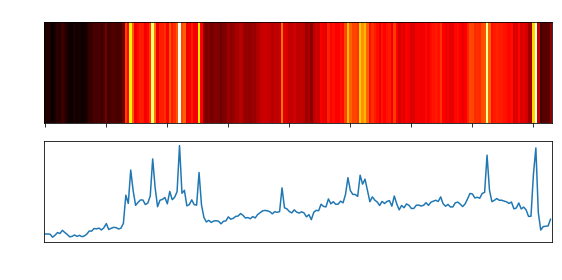

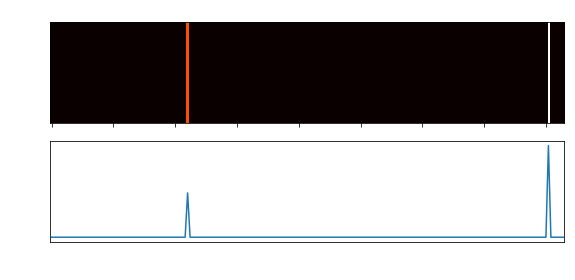

In [76]:
commt = xs[118]
tgs = ys[118]

see_results(commt, tgs)

thank you for this article , all i need to know not to vote for her . while i agree we could use some more diverse voices running for mayor and i even liked some of her background as a potential candidate ; what we don ' t need is someone who derisively lumps all middle aged white guys together . sorry but change that wording ( and from someone else ) to " another middle aged white woman " and the candidate would get hammered for sexism , ageism , etc . . . might have been a snarky comment for humor , and that is what i want for a mayor . . . someone snarky .

with prediction prob. [0.20085117]

Words focused by grad-CAM:




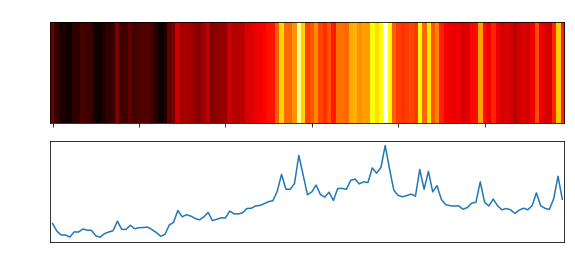

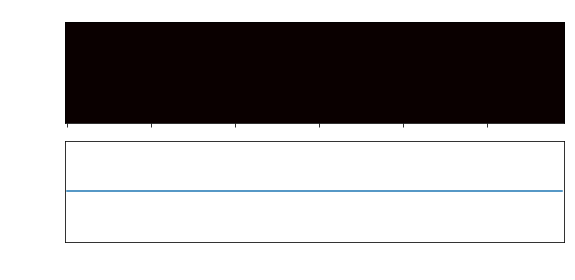

In [59]:
# labeled 0.300000, 1.000000, 1.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 1.0, 0.0
sample_str = """
Thank you for this article, all I need to know not to vote for her.   While I agree we could use some more diverse voices running for mayor and I even liked some of her background as a potential candidate; what we don't need is someone who derisively lumps all middle aged white guys together.  
Sorry but change that wording (and from someone else) to "another middle aged white woman" and the candidate would get hammered for sexism, ageism, etc...  
Might have been a snarky comment for humor, and that is what i want for a mayor...someone snarky.
"""

commt = preprocessing(sample_str)
see_results(commt[0])

this is a great story . man . i wonder if the person who yelled " shut the fuck up ! " at him ever heard it .

with prediction prob. [0.81269854]

Words focused by grad-CAM:
shut the fuck



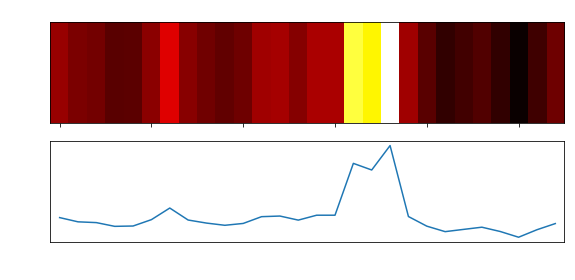

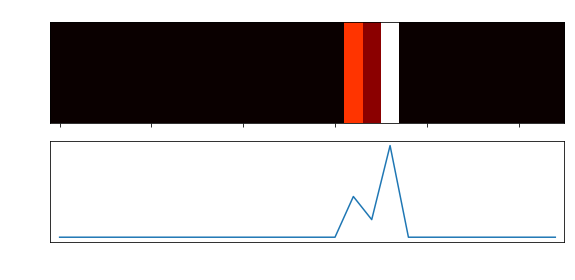

In [60]:
# labeled 0.440000, 0.600000, 0.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 0.0, 0.0
sample_str = """
This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.
"""

commt = preprocessing(sample_str)
see_results(commt[0])

my thoughts are that people should stop being stupid and ignorant . climate change scientifically proven . it isn ' t a debate .

with prediction prob. [0.81747824]
Words focused by grad-CAM:
stupid ignorant


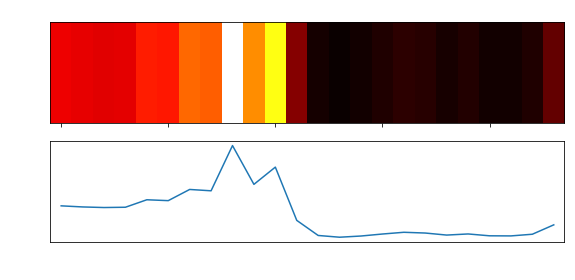

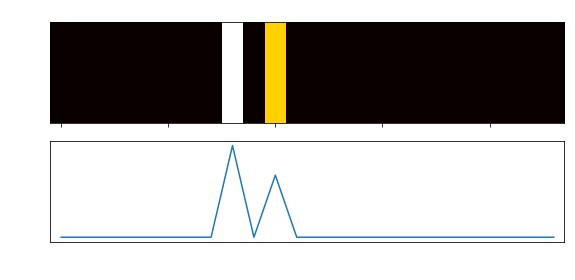

In [36]:
# labeled 0.440000, 0.600000, 0.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 0.0, 0.0
sample_str = """
My thoughts are that people should stop being stupid and ignorant. Climate change scientifically proven. It isn't a debate.
"""

commt = preprocessing(sample_str)
see_results(commt[0])

i am a gay woman .

with prediction prob. [0.5155418]

Words focused by grad-CAM:
gay



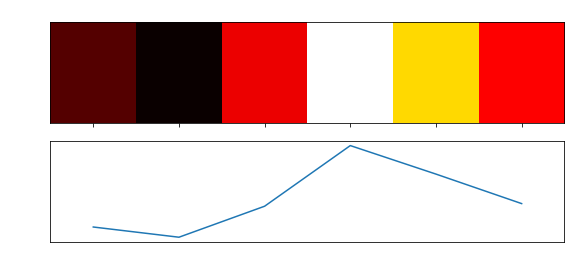

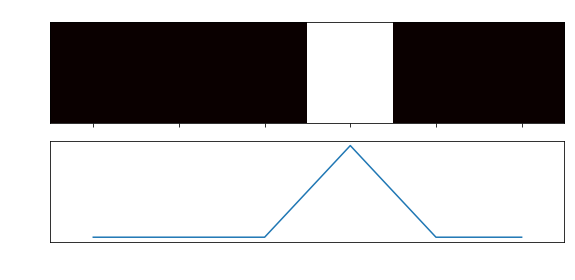

In [61]:
# labeled 0.440000, 0.600000, 0.000000, 0.0, 0.0, 0.0, 0.0, 0.00, 0.0, 0.0
sample_str = """
I am a gay woman.
"""

commt = preprocessing(sample_str)
see_results(commt[0])